In [ ]:
from sklearn.datasets import fetch_covtype
import numpy as np
import pandas as pd 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [ ]:

data = fetch_covtype()
features = data.data
y= data.target

# Using a the random seed for reproducibility
np.random.seed(42)

subset_idx = np.random.choice(features.shape[0], 10000, replace=False)
unscaled_features = features[subset_idx]
subset_y = y[subset_idx]

scaler = StandardScaler()
scaled_features =  scaler.fit_transform(unscaled_features)

print(f"Subset shape: {scaled_features.shape}")
print(f"Example class labels: {subset_y[:10]}")

print(scaled_features.mean(axis=0))
print(scaled_features.std(axis=0))


Subset shape: (10000, 54)
Example class labels: [1 2 2 2 2 3 2 1 2 2]


In [197]:

# Apply PCA to reduce dimensions
pca = PCA(n_components=45, random_state=42)  
pca_features = pca.fit_transform(scaled_features)
print(pca_features.shape)

# K-Means on PCA-reduced data
kmeans_pca = KMeans(n_clusters=7, init='k-means++', n_init=20, max_iter=50, tol=1e-5, random_state=42)
kmeans_pca.fit(pca_features)
kmeans_labels = kmeans_pca.labels_

# Silhouette Score for PCA-reduced clustering
from sklearn.metrics import silhouette_score
silhouette_pca = silhouette_score(pca_features, kmeans_pca.labels_)
print(f"Silhouette Score for PCA-reduced K-Means: {silhouette_pca}")





(10000, 45)
Silhouette Score for PCA-reduced K-Means: 0.14870386525274115


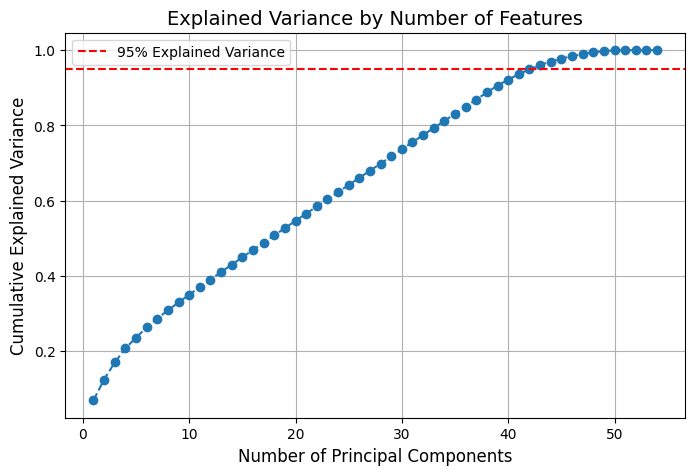

In [119]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Apply PCA to the data
pca = PCA()
pca.fit(scaled_features)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Number of Features', fontsize=14)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()


In [230]:
from sklearn.mixture import GaussianMixture

# Perform Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=7,covariance_type= "full", max_iter=100, tol=1e-4, random_state=42, init_params='kmeans')
gmm.fit(pca_features)
gmm_labels = gmm.predict(pca_features)


In [226]:
reg_covar_values = [1e-11,1e-7,1e-6, 1e-5, 1e-4, 1e-3,1e-2,1e-1]

for reg_covar in reg_covar_values:
    gmm = GaussianMixture(n_components=7, reg_covar=reg_covar, random_state=42)
    gmm.fit(scaled_features)
    print(f"Regularization: {reg_covar}, BIC: {gmm.bic(scaled_features)}")
   

Regularization: 1e-11, BIC: -5453859.092110741
Regularization: 1e-07, BIC: -2973476.1769719278
Regularization: 1e-06, BIC: -2353380.7951491806
Regularization: 1e-05, BIC: -1733284.8605894689
Regularization: 0.0001, BIC: -1113150.7828820872
Regularization: 0.001, BIC: -492237.6107026559
Regularization: 0.01, BIC: 134491.3412853903
Regularization: 0.1, BIC: 773928.4025212955


In [209]:
cov_types = ['full', 'diag', 'tied', 'spherical']
for cov_type in cov_types:
    gmm = GaussianMixture(n_components=7, covariance_type=cov_type, random_state=42)
    gmm.fit(scaled_features)
    print(f"Covariance Type: {cov_type}, BIC: {gmm.bic(scaled_features)}")


Covariance Type: full, BIC: -2353380.7951491806
Covariance Type: diag, BIC: -2097794.1075299378
Covariance Type: tied, BIC: 136727.51018859207
Covariance Type: spherical, BIC: 1171971.7012352615


In [228]:
n_clusters = 7
np.random.seed(42) 
random_labels = np.random.randint(0, n_clusters, size=scaled_features.shape[0])

print(f"Random cluster labels for first 10 datapoints: {random_labels[:10]}")
print(f"Unique cluster labels: {np.unique(random_labels)}")

Random cluster labels for first 10 datapoints: [6 3 4 6 2 4 4 6 1 2]
Unique cluster labels: [0 1 2 3 4 5 6]


In [231]:
from itertools import combinations
import numpy as np

# Function to calculate clustering errors
def calculate_clustering_errors(true_labels, cluster_labels):
    error_count = 0
    total_pairs = 0

    # Iterate over all pairs of datapoints
    for i, j in combinations(range(len(true_labels)), 2):
        if true_labels[i] == true_labels[j]:  # Same true class
            total_pairs += 1
            if cluster_labels[i] != cluster_labels[j]:  # Different cluster
                error_count += 1

    return error_count, total_pairs

# True class labels for the subset
true_labels = subset_y  # Assuming subset_y contains the true class labels

# Calculate errors for K-Means
kmeans_errors, total_pairs_kmeans = calculate_clustering_errors(true_labels, kmeans_labels)

# Calculate errors for GMM
gmm_errors, total_pairs_gmm = calculate_clustering_errors(true_labels, gmm_labels)

# # Calculate errors for the Random Baseline
random_errors, total_pairs_random = calculate_clustering_errors(true_labels, random_labels)

# Print results
print(f"K-Means Errors: {kmeans_errors} / {total_pairs_kmeans}")
print(f"GMM Errors: {gmm_errors} / {total_pairs_gmm}")
print(f"Random Baseline Errors: {random_errors} / {total_pairs_random}")


K-Means Errors: 12426423 / 18807759
GMM Errors: 8365008 / 18807759
Random Baseline Errors: 16121145 / 18807759


In [111]:
from sklearn.metrics import silhouette_score

# Define parameters
scaled_features = scaled_features
optimal_k = 7
n_init = 20
max_iter = 300
tol = 1e-4
random_state = 42

# 1. K-Means with 'k-means++' Initialization
kmeans_plus = KMeans(
    n_clusters=optimal_k, init='k-means++', n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state
)
kmeans_plus.fit(scaled_features)

# Compute metrics for 'k-means++'
ssd_plus = kmeans_plus.inertia_
silhouette_plus = silhouette_score(scaled_features, kmeans_plus.labels_)

# 2. K-Means with Random Initialization
kmeans_random = KMeans(
    n_clusters=optimal_k, init='random', n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state
)
kmeans_random.fit(scaled_features)

# Compute metrics for random initialization
ssd_random = kmeans_random.inertia_
silhouette_random = silhouette_score(scaled_features, kmeans_random.labels_)

# Print results
print(f"K-Means with 'k-means++' Initialization:")
print(f"SSD: {ssd_plus:.2f}")
print(f"Silhouette Score: {silhouette_plus:.4f}\n")

print(f"K-Means with Random Initialization:")
print(f"SSD: {ssd_random:.2f}")
print(f"Silhouette Score: {silhouette_random:.4f}")


K-Means with 'k-means++' Initialization:
SSD: 431806.75
Silhouette Score: 0.1269

K-Means with Random Initialization:
SSD: 433398.20
Silhouette Score: 0.1003


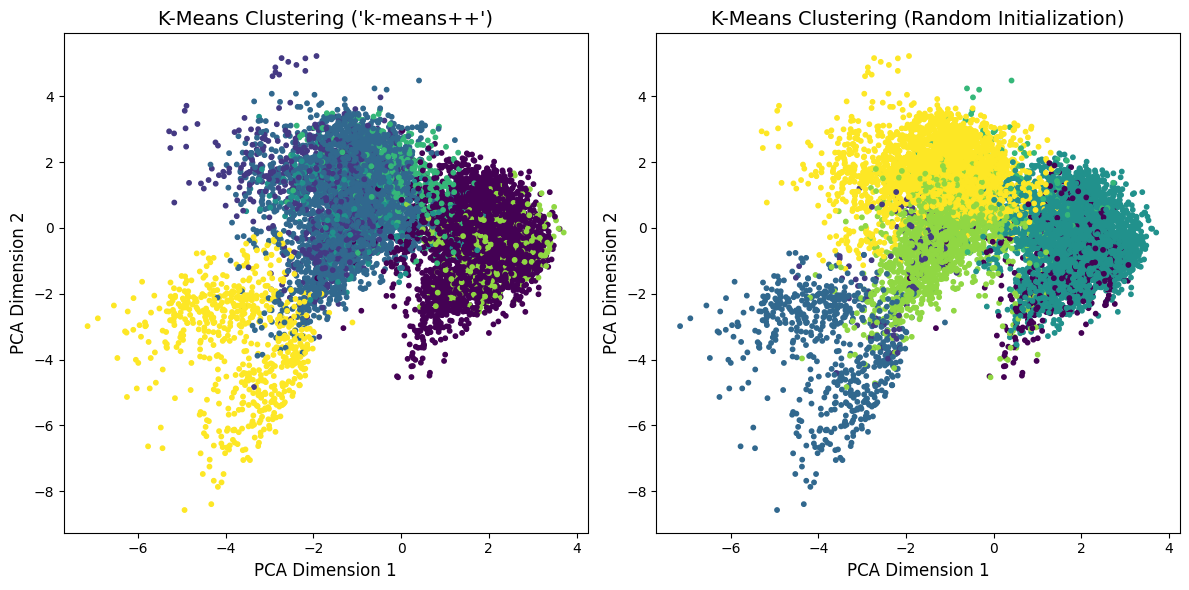

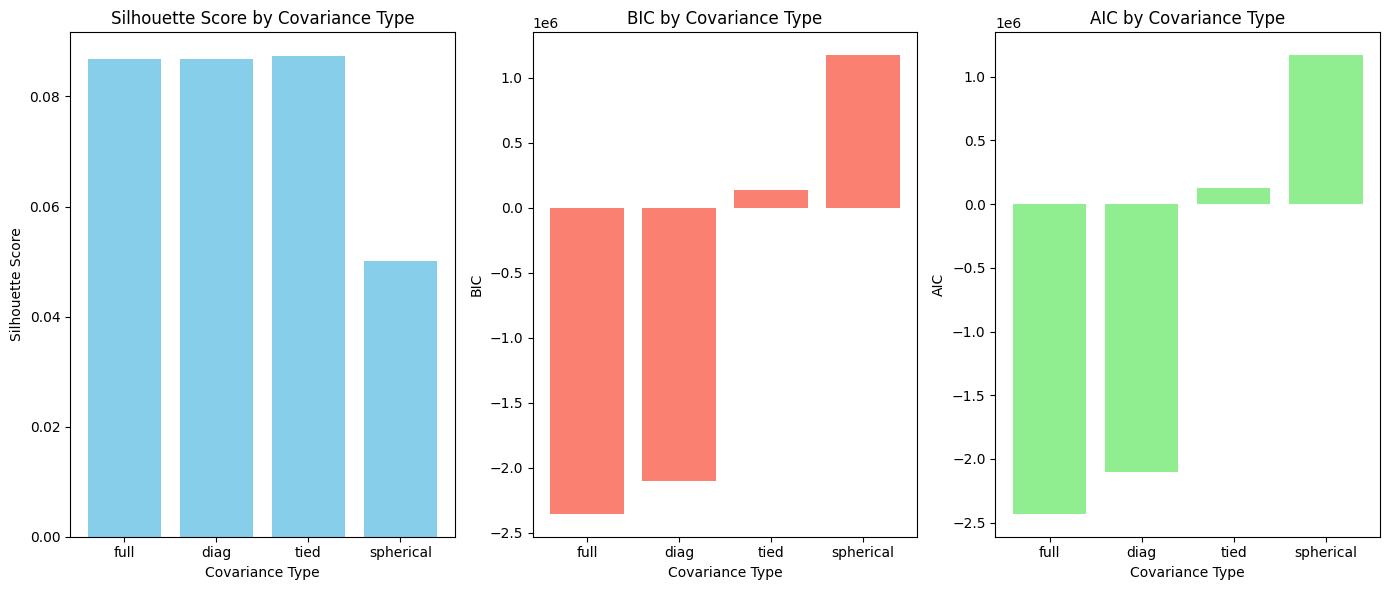

In [215]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Covariance types to test
covariance_types = ['full', 'diag', 'tied', 'spherical']

# Store results
results_cov_type = {}

for cov_type in covariance_types:
    gmm = GaussianMixture(n_components=7, covariance_type=cov_type, random_state=42)
    gmm.fit(scaled_features)
    labels = gmm.predict(scaled_features)
    
    # Compute metrics
    silhouette = silhouette_score(scaled_features, labels)
    bic = gmm.bic(scaled_features)
    aic = gmm.aic(scaled_features)
    results_cov_type[cov_type] = {'silhouette': silhouette, 'bic': bic, 'aic': aic}

# Visualize results
plt.figure(figsize=(14, 6))

# Silhouette Score
plt.subplot(1, 3, 1)
plt.bar(results_cov_type.keys(), [results_cov_type[cov]['silhouette'] for cov in covariance_types], color='skyblue')
plt.title("Silhouette Score by Covariance Type")
plt.ylabel("Silhouette Score")
plt.xlabel("Covariance Type")

# BIC
plt.subplot(1, 3, 2)
plt.bar(results_cov_type.keys(), [results_cov_type[cov]['bic'] for cov in covariance_types], color='salmon')
plt.title("BIC by Covariance Type")
plt.ylabel("BIC")
plt.xlabel("Covariance Type")

# AIC
plt.subplot(1, 3, 3)
plt.bar(results_cov_type.keys(), [results_cov_type[cov]['aic'] for cov in covariance_types], color='lightgreen')
plt.title("AIC by Covariance Type")
plt.ylabel("AIC")
plt.xlabel("Covariance Type")

plt.tight_layout()
plt.show()


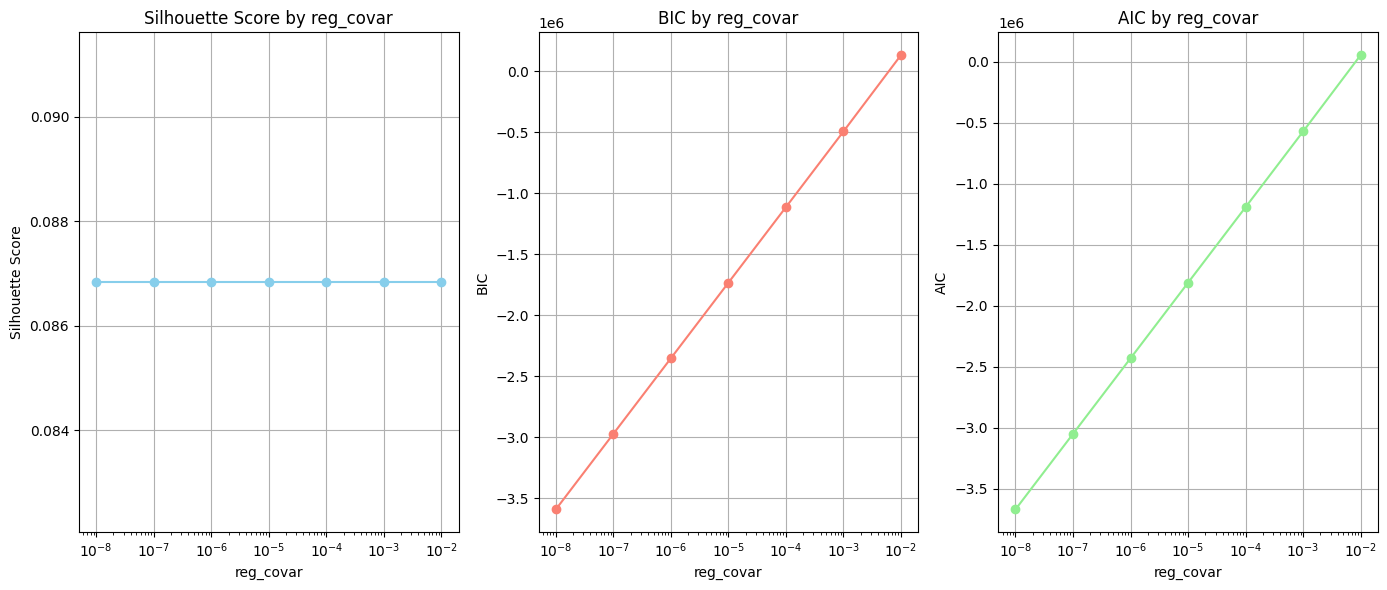

In [217]:
# Regularization values to test

reg_covar_values = [1e-8,1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

# Store results
results_reg_covar = {}

for reg_covar in reg_covar_values:
    gmm = GaussianMixture(n_components=7, reg_covar=reg_covar, random_state=42)
    gmm.fit(scaled_features)
    labels = gmm.predict(scaled_features)
    
    # Compute metrics
    silhouette = silhouette_score(scaled_features, labels)
    bic = gmm.bic(scaled_features)
    aic = gmm.aic(scaled_features)
    results_reg_covar[reg_covar] = {'silhouette': silhouette, 'bic': bic, 'aic': aic}

# Visualize results
plt.figure(figsize=(14, 6))

# Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(reg_covar_values, [results_reg_covar[reg]['silhouette'] for reg in reg_covar_values], marker='o', color='skyblue', label="Silhouette")
plt.title("Silhouette Score by reg_covar")
plt.xlabel("reg_covar")
plt.ylabel("Silhouette Score")
plt.xscale('log')
plt.grid(True)

# BIC
plt.subplot(1, 3, 2)
plt.plot(reg_covar_values, [results_reg_covar[reg]['bic'] for reg in reg_covar_values], marker='o', color='salmon', label="BIC")
plt.title("BIC by reg_covar")
plt.xlabel("reg_covar")
plt.ylabel("BIC")
plt.xscale('log')
plt.grid(True)

# AIC
plt.subplot(1, 3, 3)
plt.plot(reg_covar_values, [results_reg_covar[reg]['aic'] for reg in reg_covar_values], marker='o', color='lightgreen', label="AIC")
plt.title("AIC by reg_covar")
plt.xlabel("reg_covar")
plt.ylabel("AIC")
plt.xscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()


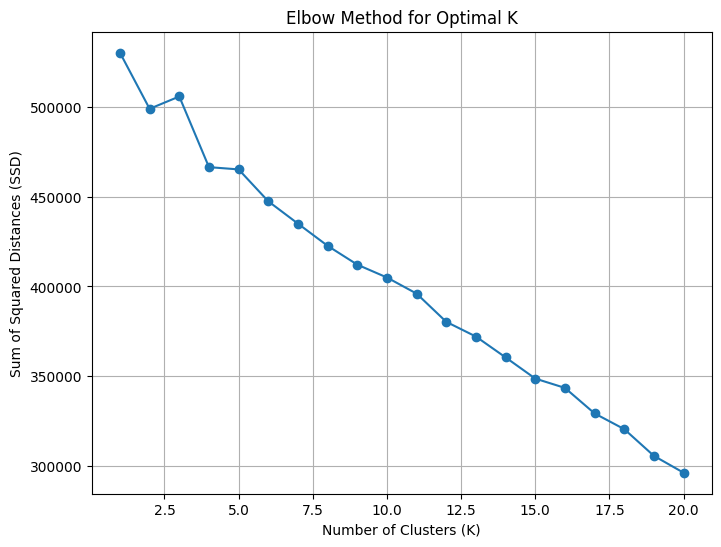

In [109]:
K_values = range(1, 21)  # Test K from 1 to 10
scores = []

# Step 2: Fit K-Means for each K and compute the score
for K in K_values:
    kmeans = KMeans(K).fit(scaled_features)
    scores.append(-kmeans.score(scaled_features))

# Step 3: Plot the Elbow Method results
plt.figure(figsize=(8, 6))
plt.plot(K_values, scores, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of Squared Distances (SSD)")
plt.grid(True)
plt.show()

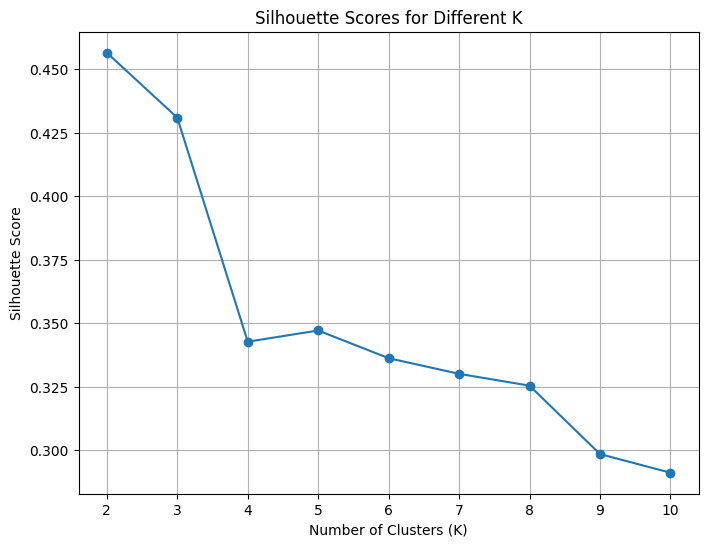

In [47]:
from sklearn.metrics import silhouette_score

K_values = range(2, 11)  # Start from K=2
silhouette_scores = []

for K in K_values:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10).fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(K_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()



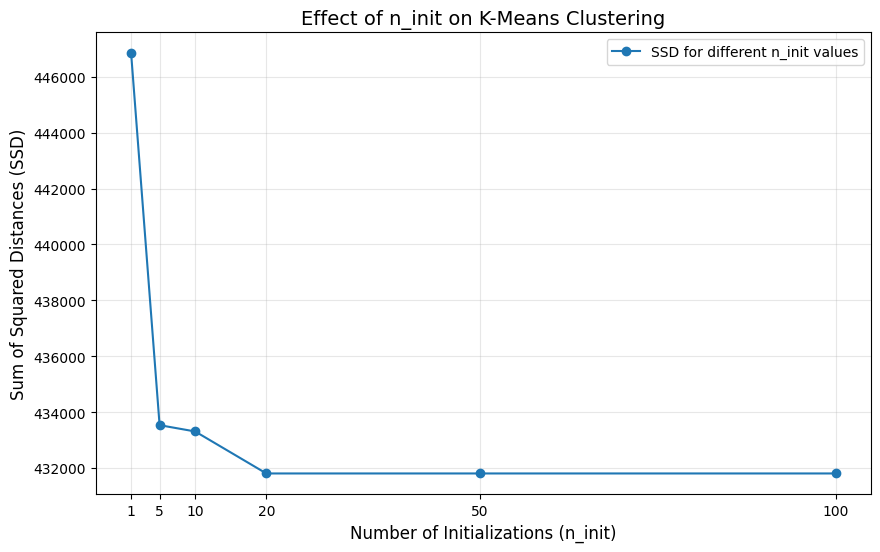

In [154]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Define n_init values to compare
n_init_values = [1, 5, 10, 20, 50,100]
ssd_results = []

# Run K-Means with different n_init values and fixed random_state
random_state = 42  # Fixed random state for reproducibility
for n_init in n_init_values:
    kmeans = KMeans(n_clusters=7, n_init=n_init, random_state=random_state)
    kmeans.fit(scaled_features)
    ssd_results.append(-kmeans.score(scaled_features))  # Negative score to get positive SSD

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(n_init_values, ssd_results, marker='o', label='SSD for different n_init values')
plt.title("Effect of n_init on K-Means Clustering", fontsize=14)
plt.xlabel("Number of Initializations (n_init)", fontsize=12)
plt.ylabel("Sum of Squared Distances (SSD)", fontsize=12)
plt.xticks(n_init_values)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.show()


In [160]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# Custom implementation of K-Means with Manhattan Distance
class KMeansManhattan(KMeans):
    def _euclidean_distances(self, X, Y=None, squared=False):
        return cdist(X, Y, metric="cityblock")  # Replace with Manhattan (Cityblock) distance

# Dataset and Parameters
n_clusters = 7

# Step 1: Run K-Means with Euclidean Distance
kmeans_euclidean = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_euclidean.fit(scaled_features)
labels_euclidean = kmeans_euclidean.labels_
ssd_euclidean = -kmeans_euclidean.score(scaled_features)
silhouette_euclidean = silhouette_score(scaled_features, labels_euclidean)

# Step 2: Run K-Means with Manhattan Distance
kmeans_manhattan = KMeansManhattan(n_clusters=n_clusters, random_state=42)
kmeans_manhattan.fit(scaled_features)
labels_manhattan = kmeans_manhattan.labels_
ssd_manhattan = np.sum(np.min(cdist(scaled_features, kmeans_manhattan.cluster_centers_, metric="cityblock"), axis=1))
silhouette_manhattan = silhouette_score(scaled_features, labels_manhattan, metric="manhattan")

# Step 3: Compare Results
print("Euclidean Distance:")
print(f"SSD: {ssd_euclidean:.2f}, Silhouette Score: {silhouette_euclidean:.2f}")
print("\nManhattan Distance:")
print(f"SSD: {ssd_manhattan:.2f}, Silhouette Score: {silhouette_manhattan:.2f}")


Euclidean Distance:
SSD: 446833.55, Silhouette Score: 0.09

Manhattan Distance:
SSD: 159200.81, Silhouette Score: 0.08


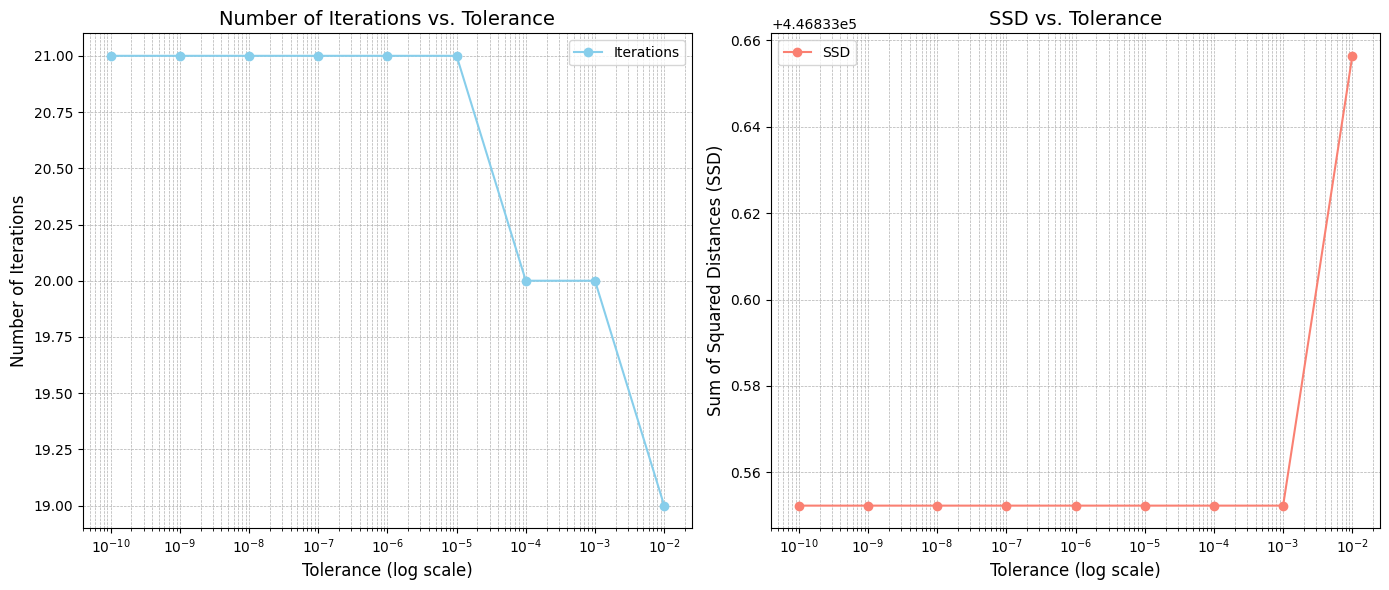

In [162]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Extended tolerances to test
tolerances = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
results_tol = {}

# Run K-Means for each tolerance
for tol in tolerances:
    kmeans = KMeans(n_clusters=7, tol=tol, max_iter=300, random_state=42)
    kmeans.fit(scaled_features)
    results_tol[tol] = {
        "iterations": kmeans.n_iter_,  # Number of iterations
        "ssd": -kmeans.score(scaled_features),  # SSD (negative score)
    }

# Plot Results for Extended Tolerances
plt.figure(figsize=(14, 6))

# Number of Iterations
plt.subplot(1, 2, 1)
plt.plot(tolerances, [results_tol[tol]["iterations"] for tol in tolerances], marker='o', color="skyblue", label="Iterations")
plt.xscale("log")
plt.title("Number of Iterations vs. Tolerance", fontsize=14)
plt.xlabel("Tolerance (log scale)", fontsize=12)
plt.ylabel("Number of Iterations", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# SSD
plt.subplot(1, 2, 2)
plt.plot(tolerances, [results_tol[tol]["ssd"] for tol in tolerances], marker='o', color="salmon", label="SSD")
plt.xscale("log")
plt.title("SSD vs. Tolerance", fontsize=14)
plt.xlabel("Tolerance (log scale)", fontsize=12)
plt.ylabel("Sum of Squared Distances (SSD)", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()


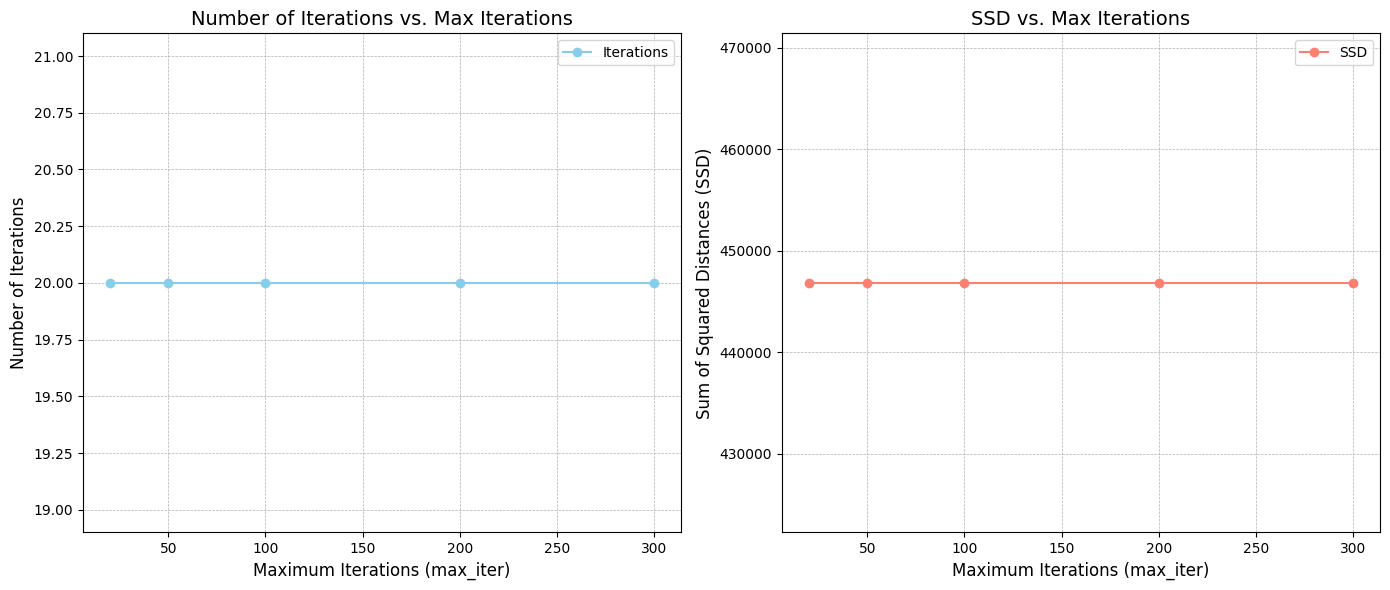

In [173]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define max_iter values to test
max_iters = [20, 50, 100, 200,300]
results_max_iter = {}

# Run K-Means for each max_iter
for max_iter in max_iters:
    kmeans = KMeans(n_clusters=7, tol=1e-4, max_iter=max_iter, random_state=42)
    kmeans.fit(scaled_features)
    results_max_iter[max_iter] = {
        "iterations": kmeans.n_iter_,  # Number of iterations performed
        "ssd": -kmeans.score(scaled_features),  # SSD (negative score)
    }

# Plot Results for Maximum Iterations
plt.figure(figsize=(14, 6))

# Number of Iterations
plt.subplot(1, 2, 1)
plt.plot(max_iters, [results_max_iter[max_iter]["iterations"] for max_iter in max_iters], marker='o', color="skyblue", label="Iterations")
plt.title("Number of Iterations vs. Max Iterations", fontsize=14)
plt.xlabel("Maximum Iterations (max_iter)", fontsize=12)
plt.ylabel("Number of Iterations", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()

# SSD
plt.subplot(1, 2, 2)
plt.plot(max_iters, [results_max_iter[max_iter]["ssd"] for max_iter in max_iters], marker='o', color="salmon", label="SSD")
plt.title("SSD vs. Max Iterations", fontsize=14)
plt.xlabel("Maximum Iterations (max_iter)", fontsize=12)
plt.ylabel("Sum of Squared Distances (SSD)", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()


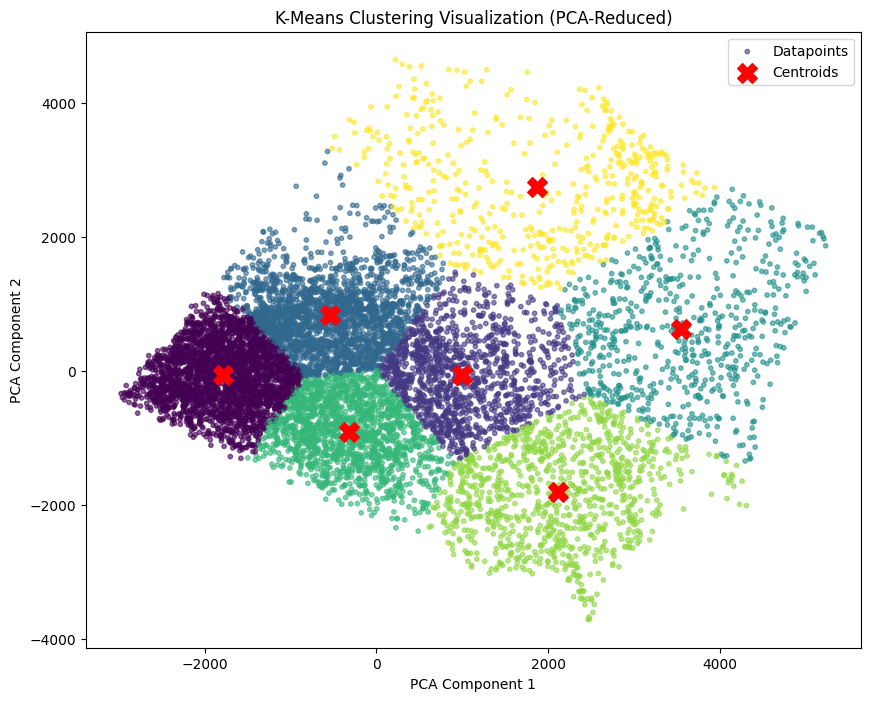

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Reduce to 2D using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
reduced_centroids = pca.transform(kmeans.cluster_centers_)


# Step 2: Plot the data points, colored by cluster
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels, cmap='viridis', s=10, alpha=0.6, label="Datapoints")
plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title("K-Means Clustering Visualization (PCA-Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [40]:
gmm = GaussianMixture(n_components=7, random_state=42, n_init = 10)
gmm.fit(scaled_features)
gmm_labels = gmm.predict(scaled_features)

print(f"Cluster labels for first 10 datapoints (GMM): {gmm_labels[:10]}")

Cluster labels for first 10 datapoints (GMM): [4 5 6 4 2 5 4 4 1 1]


In [18]:
# print("Dataset Description:")
# print(data.DESCR)

# print(pd.DataFrame(features).head())

# print("\nFirst 5 class labels (y):")
# print(y[:5])

# # Summary statistics for features
# print("\nFeature summary statistics:")
# print(pd.DataFrame(features).describe())